# Interactive Learning Course
## HW #2, Multi-Armed Bandits

# Table of Contents

- [Packages](#0)
- [Part 2](#1)
    - [Reward class](#1-1)
    - [Environment](#1-2)
- [Part 3](#2)
    - [Agent Base](#2-1)
    - [Epsilon-Greedy Agent](#2-2)
    - [Gradient-Based Agent](#2-3)
    - [Upper Confidence Bound Agent](#2-4)
- [Part 4](#3)
    - [Student](#3-1)
    - [GovStaff](#3-2)
    - [SelfEmp](#3-3)
- [Part 5](#4)
    - [Student](#4-1)
    - [GovStaff](#4-2)
    - [SelfEmp](#4-3)

<a name='0'></a>
## Packages

Run the following cell to load the packages you'll need.

In [62]:
import numpy as np
from abc import ABC, abstractmethod
import gym
import matplotlib.pyplot as plt
import math

REGRET = [5.1, 20.75, 105]

<a name='1'></a>
# Part 2

<a name='1-1'></a>
## Reward class

In [63]:
class Reward(ABC):
    def __init__(self, debts=[5.0, 20.0, 100.0]):
        super(Reward, self).__init__()
        self.debts = debts
        
    @abstractmethod
    def get_reward(self, action):
        pass

In [64]:
class Student(Reward):
    def __init__(self):
        super(Student, self).__init__()

    def get_reward(self, action):
        if action == 0:
            obs = np.random.choice([4, 5, 5.1], p=[0.2, 0.2, 0.6])
        elif action == 1:
            obs = np.random.choice([5, 10, 20, 20.75], p=[0.5, 0.3, 0.1, 0.1])
        else:
            obs = np.random.choice([10, 20, 50, 100, 105], p=[0.5, 0.3, 0.1, 0.05, 0.05])
        
        return obs, obs - self.debts[action]

In [65]:
class GovStaff(Reward):
    def __init__(self):
        super(GovStaff, self).__init__()

    def get_reward(self, action):
        if action == 0:
            obs = np.random.choice([4, 5, 5.1], p=[0.05, 0.3, 0.65])
        elif action == 1:
            obs = np.random.choice([5, 10, 20, 20.75], p=[0.1, 0.1, 0.3, 0.5])
        else:
            obs = np.random.choice([20, 50, 80, 100, 105], p=[0.1, 0.1, 0.2, 0.3, 0.3])
        
        return obs, obs - self.debts[action]

In [66]:
class SelfEmp(Reward):
    def __init__(self):
        super(SelfEmp, self).__init__()

    def get_reward(self, action):
        if action == 0:
            obs = np.random.choice([0, 2.5, 5.1], p=[0.8, 0.1, 0.1])
        elif action == 1:
            obs = np.random.choice([5, 10, 20, 20.75], p=[0.05, 0.05, 0.3, 0.6])
        else:
            obs = np.random.choice([20, 50, 80, 100, 105], p=[0.02, 0.03, 0.05, 0.2, 0.7])
        
        return obs, obs - self.debts[action]

<a name='1-2'></a>
## Environment

In [67]:
class Environment:
    def __init__(self, _id, reward):
        ## YOUR CODES ##
        self.id = _id
        self.reward = reward
        self.action_space = gym.spaces.Discrete(len(reward.debts))
    
    def calc_reward(self, action):
        ## YOUR CODES ##
        return self.reward.get_reward(action)

    def get_available_actions(self):
        ## YOUR CODES ##
        return self.action_space.n

<a name='2'></a>
# Part 3

<a name='2-1'></a>
## Agent Base

$$Utility \space Function: u=\beta \times reward^{\gamma} + \alpha$$

In [68]:
class Agent:
    def __init__(self, _id, env=None, alpha=0, beta=1, gamma=1):
        self.id = _id
        self.env = env
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.all_rewards = []
        self.all_regrets = []

    @abstractmethod
    def choose_action(self):
        pass
    
    def calculate_utility(self, reward):
        return self.beta * np.power(reward, self.gamma) + self.alpha
    
    def take_action(self, action):
        obs, reward = self.env.calc_reward(action)
        utility = self.calculate_utility(reward)
        self.update_value(action, utility)
        return reward, action, utility
    
    @abstractmethod
    def update_value(self, action, util):
        pass

    def step(self, best_reward, trial):
        for i in range(trial):
            action = self.choose_action()
            reward, action, utility = self.take_action(action)
            self.all_rewards.append(reward)
            self.all_regrets.append(REGRET[action] - reward)

    @abstractmethod
    def reset(self):
        pass
    
    def get_rewards(self):
        return self.all_rewards
    
    def get_regrets(self):
        return self.all_regrets

<a name='2-2'></a>
## Epsilon-Greedy Agent
Epsilon-Greedy is a simple method to balance exploration and exploitation by choosing between exploration and exploitation randomly.

The epsilon-greedy, where epsilon refers to the probability of choosing to explore, exploits most of the time with a small chance of exploring.

$$Action \space at \space time(t) : \pi_{act}(s) = \left\{ \begin{array}{rcl}
arg max_{a \in Actions} \hat{Q}_{opt}(s,a)     & \quad   & probability \space  1- \epsilon 
\\ random \space from \space Actions(s)  & \quad & probability \space \epsilon 
\end{array}\right.  $$

$$Number \space of \space doing \space an \space Action : N(a)$$

$$Action \space Value \space Fuction : Q(s,a) \leftarrow \frac{N(a) - 1}{N(a)} \times Q(s,a) + \frac{1}{N(a)} \times R(s,a)$$

In [69]:
class EpsilonGreedyAgent(Agent):
    def __init__(self, _id, env, alpha=0, beta=1, gamma=1, epsilon=0.1):
        super(EpsilonGreedyAgent, self).__init__(_id, env, alpha, beta, gamma)
        self.epsilon = epsilon
        self.available_actions = self.env.get_available_actions()
        self.N = np.zeros((self.available_actions,1))     # number of doing an action 
        self.Q = np.zeros((self.available_actions,1))     # action value fuction

    def choose_action(self):
        p = np.random.rand()
        if p < self.epsilon:
            action = np.random.choice(self.available_actions)
        else:
            action = np.argmax(self.Q)
        return action
    
    def update_value(self, action, util):
        self.N[action] += 1
        self.Q[action] = (util + self.Q[action] * (self.N[action] - 1)) / self.N[action]

    def reset(self):
        self.all_rewards = []
        self.all_regrets = []
        self.N = np.zeros((self.available_actions,1))
        self.Q = np.zeros((self.available_actions,1))

<a name='2-3'></a>
## Gradient-Based Agent

$$Action \space Preferences\space Function : H_t(A) = \left\{ \begin{array}{rcl}
H_{t+1}(A_t) \doteq H_{t}(A_t) + \alpha(R_t - \bar{R}_t) (1-\pi_t(A_t))     & \quad   & and
\\ H_{t+1}(a) \doteq H_{t}(a) - \alpha(R_t - \bar{R}_t) \pi_t(a)  & \quad & for \space all \space a \ne A_t
\end{array}\right.  $$

$$ Probability\space of \space an \space Action : Pr\{A_t = a\} \doteq \frac{e^{H_t(a)}}{\sum_{b=1}^{k} e^{H_t(b)}} \doteq \pi_{t}(a) $$

In [70]:
class GradientBasedAgent(Agent):
    def __init__(self, _id, env, alpha=0, beta=1, gamma=1, learning_rate=0.0005):
        super(GradientBasedAgent, self).__init__(_id, env, alpha, beta, gamma)
        self.learning_rate = learning_rate
        self.available_actions = self.env.get_available_actions()
        self.average_reward = 0   
        self.N = 0                                       # number of time receiving a reward
        self.H = np.zeros((self.available_actions))      # action preferences function
        self.Pr = (1 / self.available_actions) * np.ones((self.available_actions))     # probability of choosing an action

    def choose_action(self):
        action = int(np.random.choice(list(range(self.available_actions)), size=1,p=self.Pr))
        return action
    
    def update_value(self, action, util):
        self.N += 1
        self.average_reward = (util + self.average_reward * (self.N - 1)) / self.N
        for i in range(len(self.H)):
            if i == action :
                self.H[i] = self.H[i] + self.learning_rate * (util - self.average_reward) * (1 - self.Pr[i])
            else:
                self.H[i] = self.H[i] - self.learning_rate * (util - self.average_reward) * (self.Pr[i])
        for i in range(len(self.Pr)):
            self.Pr[i] = np.exp(self.H[i]) / np.sum(np.exp(self.H))

    def reset(self):
        self.all_rewards = []
        self.all_regrets = []
        self.average_reward = 0   
        self.N = 0      
        self.H = np.zeros((self.available_actions))
        self.Pr = (1 / self.available_actions) * np.ones((self.available_actions))

<a name='2-4'></a>
## Upper Confidence Bound Agent
Upper-Confidence Bound action selection uses uncertainty in the action-value estimates for balancing exploration and exploitation. Since there is inherent uncertainty in the accuracy of the action-value estimates when we use a sampled set of rewards thus UCB uses uncertainty in the estimates to drive exploration.

$Q_t(a)$ here represents the current estimate for action a at time t. We select the action that has the highest estimated action-value plus the upper-confidence bound exploration term.


$$Number \space of \space times \space that \space Action \space a \space has \space been \space selected : N(a)$$

$$Action \space Value \space Fuction : Q(s,a) \leftarrow \frac{N(a) - 1}{N(a)} \times Q(s,a) + \frac{1}{N(a)} \times R(s,a)$$

$$Upper \space Confidence \space Bound \space for \space each \space Action : A_t \doteq \underset{a}{argmax} \left[ Q_t(a) + c \sqrt{\frac{\ln t}{N_t(a)}} \right]$$

In [71]:
class UpperConfidenceBoundAgent(Agent):
    def __init__(self, _id, env, alpha=0, beta=1, gamma=1, c=4):
        super(UpperConfidenceBoundAgent, self).__init__(_id, env, alpha, beta, gamma)
        self.c = c                                                    # exploration degree
        self.available_actions = self.env.get_available_actions()
        self.N = np.zeros((self.available_actions,1))                 # number of doing an action 
        self.Q = np.zeros((self.available_actions,1))                 # action value fuction
        self.total_trials = 0                                          
        self.UCB_of_actions = 10000000000000000 * np.ones((self.available_actions,1))  # Upper confidence bound for each action 

    def choose_action(self):
        action = np.argmax(self.UCB_of_actions)
        return action
    
    def update_value(self, action, util):
        self.total_trials += 1
        self.N[action] += 1
        self.Q[action] = (util + self.Q[action] * (self.N[action] - 1)) / self.N[action]
        self.UCB_of_actions[action] = self.Q[action] + self.c * math.sqrt(np.log(self.total_trials) / self.N[action])

    def reset(self):
        self.all_rewards = []
        self.all_regrets = []     
        self.N = np.zeros((self.available_actions,1))
        self.Q = np.zeros((self.available_actions,1)) 
        self.total_trials = 0                                         
        self.UCB_of_actions = 10000000000000000 * np.ones((self.available_actions,1))

<a name='3'></a>
# Part 4

In [72]:
def draw_ylabel_trial_plot_part_4(rewards, _ylabel, _title, trial):   
    plt.figure(figsize=(8,6))
    plt.plot(range(1, trial+1), rewards[0], label="Epsilon-Greedy")
    plt.plot(range(1, trial+1), rewards[1], label="Gradient-Based")
    plt.plot(range(1, trial+1), rewards[2], label="Upper Confidence Bound")
    plt.ylabel(_ylabel)
    plt.xlabel('Trials')
    plt.title(_title)
    plt.legend()
    plt.grid()
    plt.show()

In [73]:
def run_part_4(customer_type, customer_name, epsilon, learning_rate, c, number_of_run, trial):
    agent_1 = EpsilonGreedyAgent(0, env=Environment(0, customer_type), epsilon=epsilon)
    agent_2 = GradientBasedAgent(0, env=Environment(0, customer_type), learning_rate=learning_rate)
    agent_3 = UpperConfidenceBoundAgent(0, env=Environment(0, customer_type), c=c)

    mean_rewards = [np.zeros(trial)] * 3
    mean_regrets = [np.zeros(trial)] * 3

    for run in range(1, number_of_run+1):
        agent_1.step(0, trial)
        rewards = agent_1.get_rewards()
        mean_rewards[0] = (mean_rewards[0] * (run-1) + rewards) / run
        regrets = agent_1.get_regrets()
        mean_regrets[0] = (mean_regrets[0] * (run-1) + regrets) / run
        agent_1.reset()

        agent_2.step(0, trial)
        rewards = agent_2.get_rewards()
        mean_rewards[1] = (mean_rewards[1] * (run-1) + rewards) / run
        regrets = agent_2.get_regrets()
        mean_regrets[1] = (mean_regrets[1] * (run-1) + regrets) / run
        agent_2.reset()

        agent_3.step(0, trial)
        rewards = agent_3.get_rewards()
        mean_rewards[2] = (mean_rewards[2] * (run-1) + rewards) / run
        regrets = agent_3.get_regrets()
        mean_regrets[2] = (mean_regrets[2] * (run-1) + regrets) / run
        agent_3.reset()

    draw_ylabel_trial_plot_part_4(mean_rewards, "Reward", customer_name, trial)
    draw_ylabel_trial_plot_part_4(mean_regrets, "Regret", customer_name, trial)

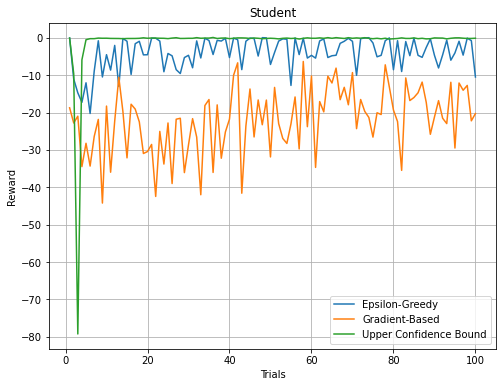

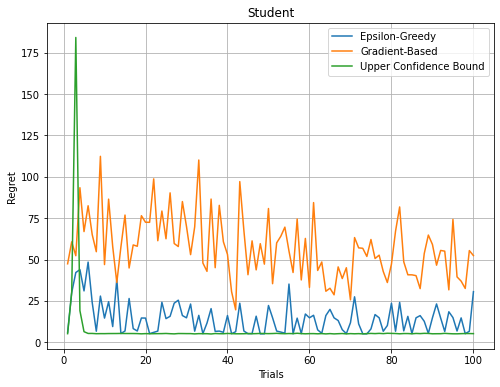

In [74]:
run_part_4(customer_type=Student(), customer_name="Student", epsilon=0.1, learning_rate=0.0005, c=4, number_of_run=20, trial=100)

<a name='3-1'></a>
## Student

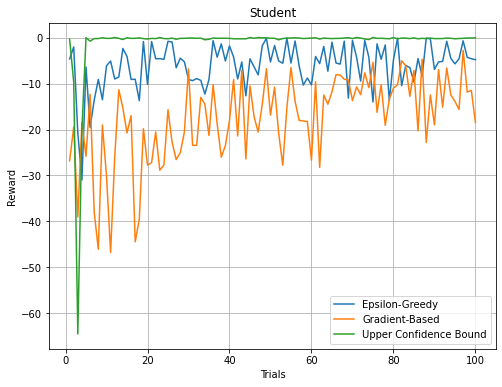

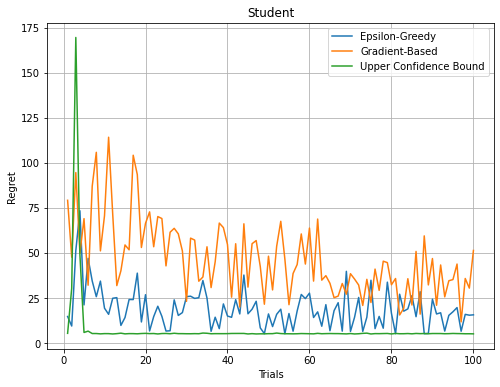

In [75]:
run_part_4(customer_type=Student(), customer_name="Student", epsilon=0.2, learning_rate=0.001, c=2, number_of_run=20, trial=100)

<a name='3-2'></a>
## GovStaff

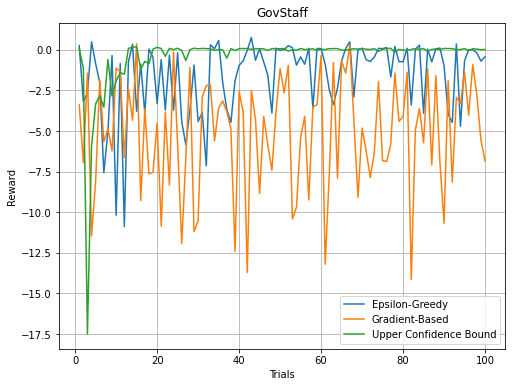

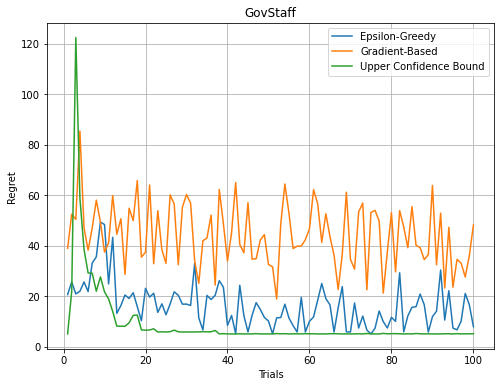

In [76]:
 run_part_4(customer_type=GovStaff(), customer_name="GovStaff", epsilon=0.2, learning_rate=0.001, c=2, number_of_run=20, trial=100)

<a name='3-3'></a>
## SelfEmp

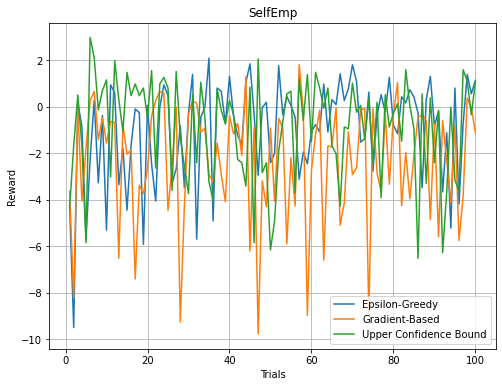

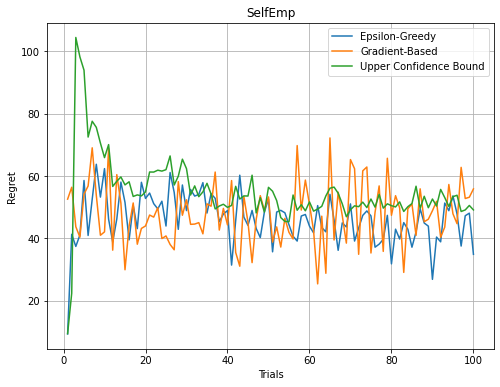

In [77]:
run_part_4(customer_type=SelfEmp(), customer_name="SelfEmp", epsilon=0.2, learning_rate=0.001, c=2, number_of_run=20, trial=100)

<a name='4'></a>
# Part 5

In [79]:
def draw_ylabel_trial_plot_part_5(rewards, _ylabel, _title, labels, trial):   
    plt.figure(figsize=(12,9))
    for i in range(len(learning_rates)):
        plt.plot(range(1, trial+1), rewards[i], label="Gradient-Based (learning rates="+str(labels[i])+")")
    plt.ylabel(_ylabel)
    plt.xlabel('Trials')
    plt.title(_title)
    plt.legend()
    plt.grid()
    plt.show()

In [80]:
def run_part_5(customer_type, customer_name, learning_rates, number_of_run, trial):
    mean_rewards = [np.zeros(trial)] * len(learning_rates)
    mean_regrets = [np.zeros(trial)] * len(learning_rates)
    
    for i in range(len(learning_rates)):
        agent_2 = GradientBasedAgent(0, env=Environment(0, customer_type), learning_rate=learning_rates[i])

        for run in range(1, number_of_run+1):
            agent_2.step(0, trial)
            rewards = agent_2.get_rewards()
            mean_rewards[i] = (mean_rewards[i] * (run-1) + rewards) / run
            regrets = agent_2.get_regrets()
            mean_regrets[i] = (mean_regrets[i] * (run-1) + regrets) / run
            agent_2.reset()

    draw_ylabel_trial_plot_part_5(mean_rewards, "Reward", customer_name, learning_rates, trial)
    draw_ylabel_trial_plot_part_5(mean_regrets, "Regret", customer_name, learning_rates, trial)

In [85]:
# learning_rates = [0.0005, 0.001, 0.005, 0.01]
# learning_rates = [0.005, 0.01, 0.05, 0.1]
learning_rates = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]

trial = 20

<a name='4-1'></a>
## Student

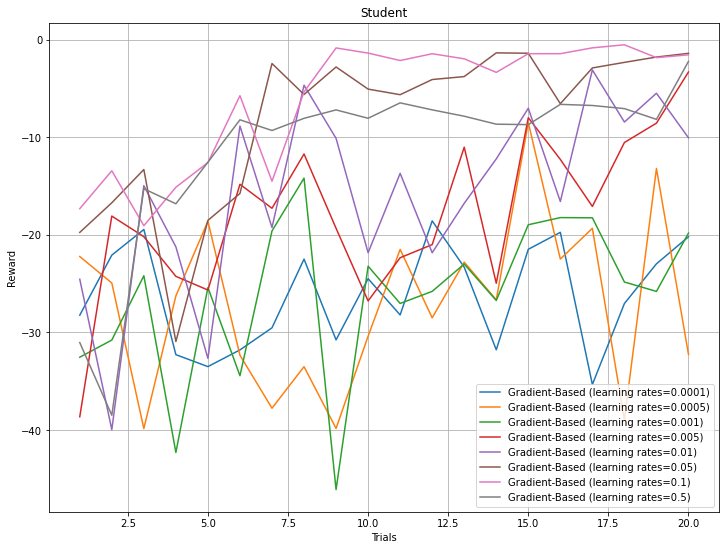

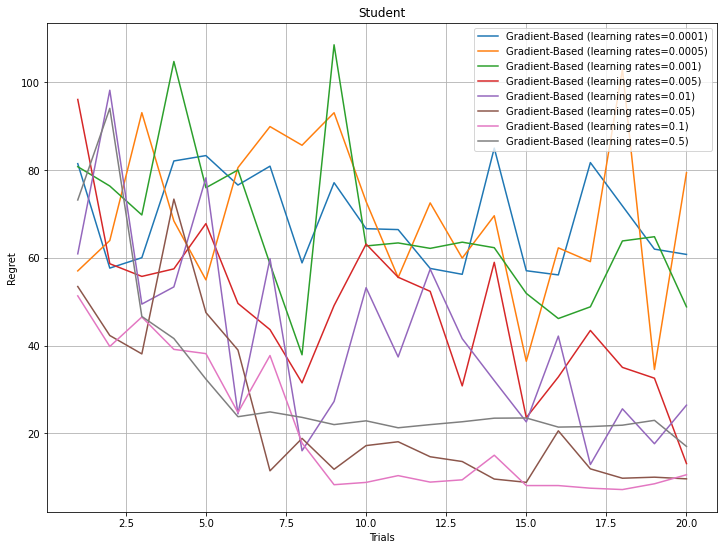

In [86]:
run_part_5(Student(), "Student", learning_rates, number_of_run=20, trial=trial)

<a name='4-2'></a>
## GovStaff

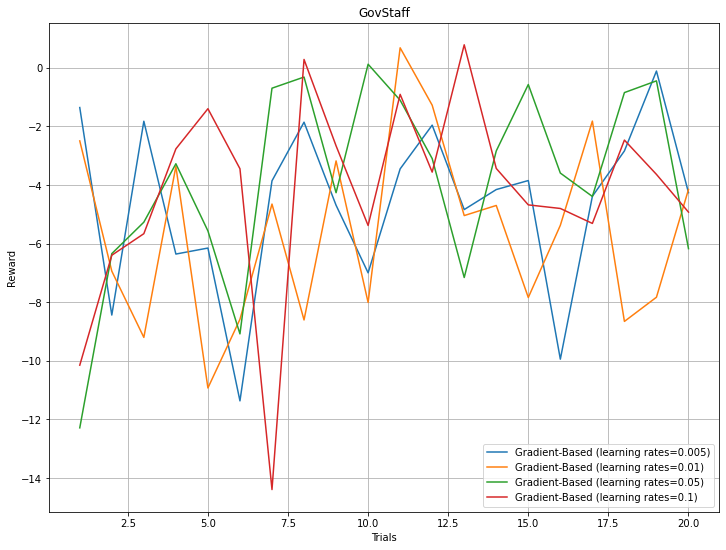

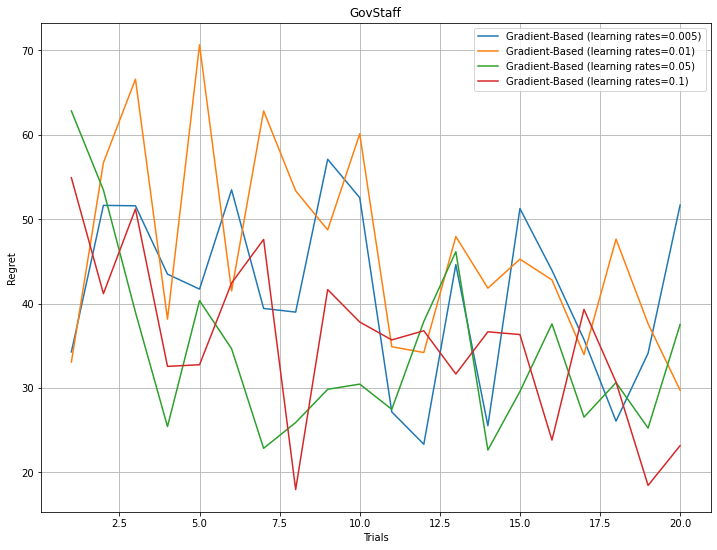

In [270]:
run_part_5(GovStaff(), "GovStaff", learning_rates, number_of_run=20, trial=trial)

<a name='4-3'></a>
## SelfEmp

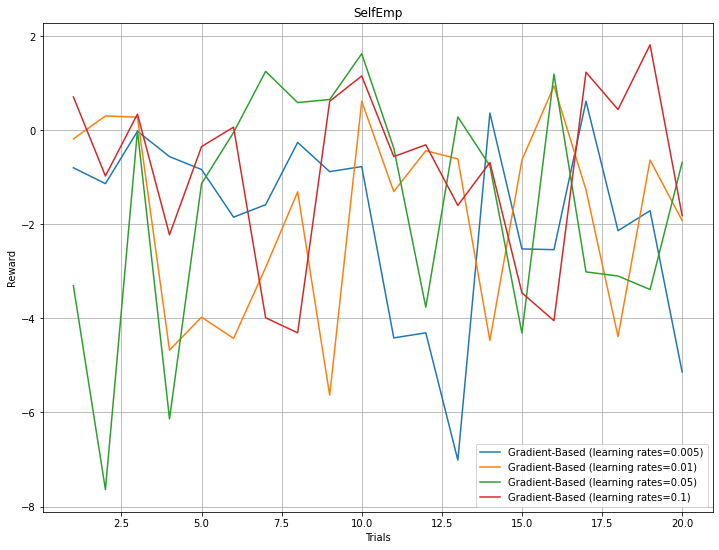

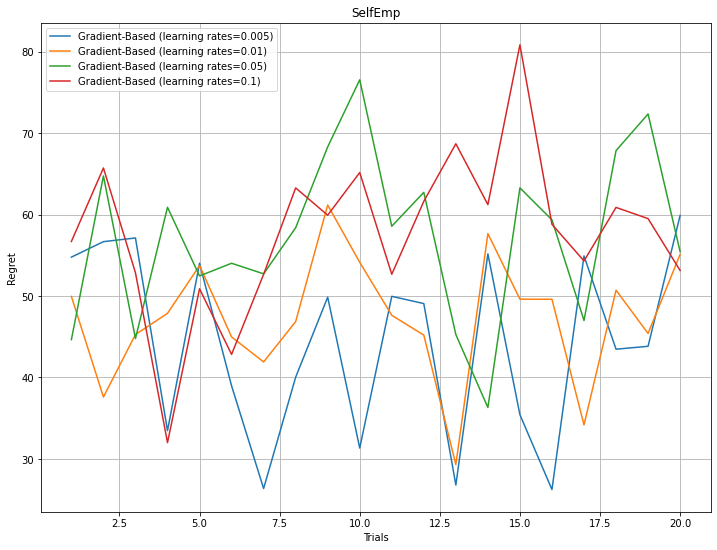

In [271]:
run_part_5(SelfEmp(), "SelfEmp", learning_rates, number_of_run=20, trial=trial)